<div style="text-align: right">Author: Cristóbal Silva / crsilva@ing.uchile.cl </div>

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

sys.path.append('..')
from gpwink_tf import GLOBAL_DTYPE
from gpwink_tf.complex import ComplexGaussian
from gpwink_tf.inducing import FilterInducingVariable, NoiseInducingVariable
from gpwink_tf.integrable import GaussianSquareExponentialKernel, GaussianSquareExponentialWindow
from gpwink_tf.model import GPWiNK
from gpwink_tf.utils import np_decaying_square_exponential

plt.ion()
np.random.seed(42)

Current issues:
- ELBO now minimizing but fails after some iterations depending on nv (non-invertible stuff, nv=50 on iter=31)
- Models may converge but still give mediocre results (nv=2, nv=10)

# Gaussian Processes with Non-Parametric Kernels

Based on the Gaussian Process Convolutional model where the observed process $y$ is defined by the latent convolution process $f$:

$$f(t) = \int_{\mathbb{R}}h(t-\tau)x(\tau)d\tau$$
$$y(t) = f(t) + \eta(t)$$

where $x$ is a white noise process and $h$ is a smooth function referred to as *filter* and $\eta$ is also white noise.

The idea is to learn the parameters that compose the kernel of $f$ given $h$, which is done via variational inference and inter-domain inducing variables.

Explicit derivations will be written once the model proves to work under a considerable number of cases.

### Define Helper Functions

These are to evaluate Tensorflow Variables and Tensor without too much overhead.

In [2]:
def eval(expr, dtype=np.float64):
    val = sess.run(expr)
    if not isinstance(val, np.ndarray):
        out = pd.DataFrame(np.array(val)[None])
    else:
        out = pd.DataFrame(val)
    return out.astype(dtype).round(2)

In [3]:
def show(expr, figsize=(15, 15)):
    plt.figure(figsize=figsize)
    sns.heatmap(eval(expr), annot=True, cmap='gray')

In [4]:
def show_real(expr, figsize=(15, 15)):
    plt.figure(figsize=figsize)
    sns.heatmap(eval(expr, dtype=np.complex64).values.real, annot=True, cmap='gray')
    
def show_imag(expr, figsize=(15, 15)):
    plt.figure(figsize=figsize)
    sns.heatmap(eval(expr, dtype=np.complex64).values.imag, annot=True, cmap='gray')

## 1. Data Generation

In [5]:
num_points = 201
final = 200
num_observed = 100
t_data = np.linspace(0, final, num_points)
gram = np_decaying_square_exponential(t_data, alpha=0, gamma=1 / 10 ** 2) + 0.00001 * np.eye(num_points)
data = np.random.multivariate_normal(t_data * 0, gram)
index_observed = np.random.choice(num_points, num_observed)
t_observed = t_data[index_observed]
data_observed = data[index_observed]

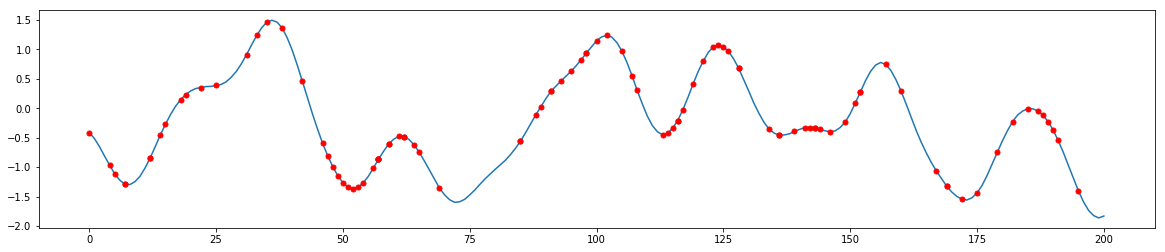

In [6]:
plot=True
if plot:
    fig = plt.figure(figsize=(20, 4))
    plt.plot(t_data, data)
    plt.plot(t_observed, data_observed, '.r', ms=10)
    plt.show()

## 2. Build GPWiNK Model

In [7]:
sess = tf.InteractiveSession()

Set number of inducing variables for $h$ and $x$

In [8]:
nu = 10
nv = 100

Build filter kernel $K_h$

In [9]:
k_sigma  = tf.Variable([[1.0]], dtype=tf.float64, name='k_sigma')
k_gamma  = tf.Variable([[1.0]], dtype=tf.float64, name='k_gamma')
k_alpha  = tf.Variable([[0.01]], dtype=tf.float64, name='k_alpha')
filter_kernel = GaussianSquareExponentialKernel.new_kernel(k_sigma, k_gamma, k_alpha)

Build interdomain inducing variables $u$ and $v$

In [10]:
# inducing filter
u_locations = np.linspace(-10, 10, nu)[:, None]

u_sigma   = tf.Variable(np.ones((nu, 1)), dtype=tf.float64, name='u_sigma')
u_gamma   = tf.Variable(np.ones((nu, 1)), dtype=tf.float64, name='u_gamma')  # np.random.rand(nu, 1) + 0.5,
u_centre  = tf.Variable(u_locations, dtype=tf.float64, name='u_centre')
u_j_omega = tf.Variable(np.ones((nu, 1)), dtype=tf.float64, name='u_j_omega')
u_j_phi   = tf.Variable(np.ones((nu, 1)), dtype=tf.float64, name='u_j_phi')

In [11]:
filter_interdomain_transform  = GaussianSquareExponentialWindow.new_window(
    u_sigma, 
    u_gamma, 
    u_centre, 
    u_j_omega, 
    u_j_phi
)
filter_inducing = FilterInducingVariable(
    locations=u_centre,
    interdomain_transform=filter_interdomain_transform, 
    kernel=filter_kernel 
)

In [12]:
# inducing noise
v_locations = np.linspace(0, final, nv)[:, None]

v_sigma   = tf.Variable(tf.ones((nv, 1), dtype=tf.float64), name='v_sigma')
v_gamma   = tf.Variable(tf.ones((nv, 1), dtype=tf.float64), name='v_gamma')
v_centre  = tf.Variable(v_locations, dtype=tf.float64, name='v_centre')
v_j_omega = tf.Variable(tf.ones((nv, 1), dtype=tf.float64), name='v_j_omega')
v_j_phi   = tf.Variable(tf.ones((nv, 1), dtype=tf.float64), name='v_j_phi')

In [13]:
noise_interdomain_transform = GaussianSquareExponentialWindow.new_window(
    v_sigma, 
    v_gamma, 
    v_centre, 
    v_j_omega, 
    v_j_phi
)
noise_inducing = NoiseInducingVariable(
    locations=v_centre, 
    interdomain_transform=noise_interdomain_transform, 
)

Build Variational approximators $q_u$ and $q_v$

In [14]:
# variational u
qu_mean  = tf.Variable(np.ones((nu, 1)) + 10 * np.random.rand(nu, 1), name='qu_mean') #+ 1j * np.random.rand(n_u, 1)
qu_alpha = tf.Variable(np.random.rand(nu, nu), dtype=tf.float64, name='qu_alpha')
qu_beta  = tf.Variable(np.random.rand(nu, nu), dtype=tf.float64, name='qu_beta')
qu_gamma = tf.Variable(np.random.rand(nu, nu), dtype=tf.float64, name='qu_gamma')
qu_delta = tf.Variable(np.random.rand(nu, nu), dtype=tf.float64, name='qu_delta')

filter_variational = ComplexGaussian.from_params(qu_mean, qu_alpha, qu_beta, qu_gamma, qu_delta)

In [15]:
# variational v
qv_mean  = tf.Variable(np.random.rand(nv, 1), name='qv_mean') #+ 1j * np.random.rand(n_v, 1)
qv_alpha = tf.Variable(np.random.rand(nv, nv), dtype=tf.float64, name='qv_alpha')
qv_beta  = tf.Variable(np.random.rand(nv, nv), dtype=tf.float64, name='qv_beta')
qv_gamma = tf.Variable(np.random.rand(nv, nv), dtype=tf.float64, name='qv_gamma')
qv_delta = tf.Variable(np.random.rand(nv, nv), dtype=tf.float64, name='qv_delta')

noise_variational = ComplexGaussian.from_params(qv_mean, qv_alpha, qv_beta, qv_gamma, qv_delta)

Create GPWiNK Object

In [16]:
t_observed = tf.convert_to_tensor(t_data[index_observed], dtype=GLOBAL_DTYPE)
data_observed = tf.convert_to_tensor(data[index_observed], dtype=GLOBAL_DTYPE)

gpwink = GPWiNK(
    t_obs=t_observed,
    y_obs=data_observed,
    filter_kernel=filter_kernel,
    filter_inducing=filter_inducing,
    noise_inducing=noise_inducing,
    filter_variational=filter_variational,
    noise_variational=noise_variational
)

In [17]:
elbo = gpwink.elbo()

In [18]:
sess.run(tf.global_variables_initializer())

Get moments and calculate ELBO before optimization

In [19]:
mean0 = sess.run(
    tf.cast(
        tf.map_fn(
            gpwink.mean, 
            tf.constant(t_data, dtype=GLOBAL_DTYPE)
        ), 
        dtype=tf.float64
    )
).squeeze()

var0 = sess.run(
    tf.cast(
        tf.map_fn(
            gpwink.second_moment, 
            tf.constant(t_data, dtype=GLOBAL_DTYPE)
        ), 
        dtype=tf.float64)
).squeeze() - mean0**2

noise_variational_mean0  = sess.run(gpwink.noise_variational._mean)
filter_variational_mean0 = sess.run(gpwink.filter_variational._mean)

Evaluate prior ELBO

In [20]:
eval(tf.cast(elbo, dtype=np.float64))

,0
0,16856.51


Plot initial mean of the of the noise variational aproximation

/home/canas/Programs/anaconda3/envs/tf/lib/python3.6/site-packages/pandas/core/dtypes/cast.py:636: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype)


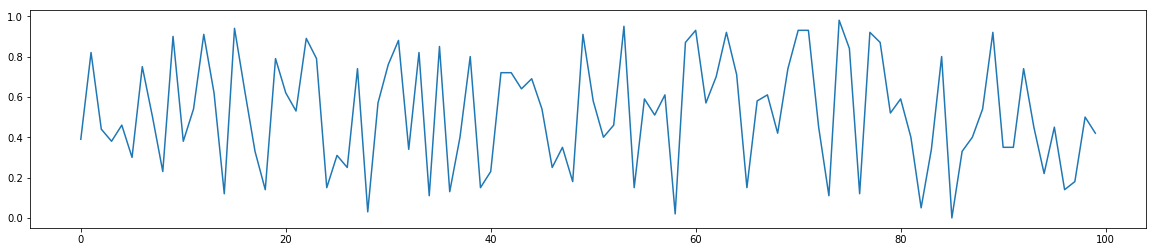

In [21]:
plt.figure(figsize=(20, 4))
plt.plot(eval(gpwink.noise_variational._mean))

Plot the mean of the filter variational approximation

/home/canas/Programs/anaconda3/envs/tf/lib/python3.6/site-packages/pandas/core/dtypes/cast.py:636: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype)


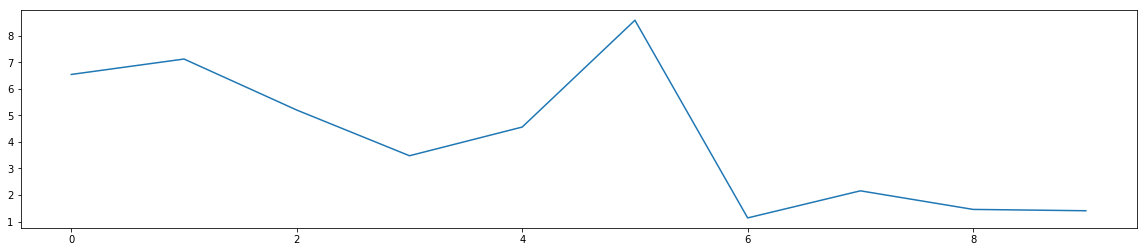

In [22]:
plt.figure(figsize=(20, 4))
plt.plot(eval(gpwink.filter_variational._mean))

## 3. Optimization

There are currently to ways of optimizing:
- Clipping weights to 0 to avoid issues with negative parameters
- Unrestricted optimization

Both are unstable in the long term due to the invertibility of some matrices, but clipping weights has proven the more stable of the two options.

In [23]:
clip = True

if not clip:
    loss = tf.cast(-elbo, tf.float64)
    opt = tf.train.GradientDescentOptimizer(1e-7)
    train = opt.minimize(loss)
else:
    all_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    all_vars_dict = {i: all_vars[i].name for i in range(len(all_vars))}
    all_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    loss = tf.cast(-elbo, tf.float64)
    opt = tf.train.GradientDescentOptimizer(1e-7)
    grads_and_vars = opt.compute_gradients(loss, all_vars)
    clipped_grads_and_vars = [(tf.clip_by_value(g, 0, 10000), v) for g, v in grads_and_vars]
    train = opt.apply_gradients(clipped_grads_and_vars)

Create a saver object to recover the parameters if the training crashes

In [24]:
saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

Train the model (minimize ELBO)

In [25]:
n_epochs = 100

losses = []
print(f'initial value: {sess.run(loss)}')
for i in range(1, n_epochs):
    sess.run(train)
    elbo = sess.run(loss)
    losses.append(elbo)
    print(f'epoch {i}/{n_epochs}: {elbo}')
    saver.save(sess, './model/gpwink-vars', global_step=i)

initial value: [[-16856.51171875]]
epoch 1/100: [[-18419.54101562]]
epoch 2/100: [[-20189.94140625]]
epoch 3/100: [[-21717.60351562]]
epoch 4/100: [[-23424.78125]]
epoch 5/100: [[-24870.90820312]]
epoch 6/100: [[-26546.64453125]]
epoch 7/100: [[-27907.02148438]]
epoch 8/100: [[-29382.73242188]]
epoch 9/100: [[-30593.03710938]]
epoch 10/100: [[-31713.09765625]]
epoch 11/100: [[-33113.734375]]
epoch 12/100: [[-34451.44140625]]
epoch 13/100: [[-35444.796875]]
epoch 14/100: [[-36725.14453125]]
epoch 15/100: [[-37865.4921875]]
epoch 16/100: [[-39199.48828125]]
epoch 17/100: [[-40601.96875]]
epoch 18/100: [[-42570.12109375]]
epoch 19/100: [[-46710.2421875]]
epoch 20/100: [[-54796.28515625]]
epoch 21/100: [[-74780.5078125]]
epoch 22/100: [[-120521.015625]]
epoch 23/100: [[-208721.40625]]
epoch 24/100: [[-373716.40625]]
epoch 25/100: [[-626158.75]]
epoch 26/100: [[-509210.21875]]
epoch 27/100: [[-1007674.25]]
epoch 28/100: [[-1355523.75]]
epoch 29/100: [[-2313796.]]
epoch 30/100: [[ nan]]


InvalidArgumentError: Input matrix is not invertible.
	 [[Node: elbo/au_inverse_time_qu_mean = MatrixSolve[T=DT_COMPLEX64, adjoint=false, _device="/job:localhost/replica:0/task:0/cpu:0"](elbo/add_59, elbo/concat_3)]]

Caused by op 'elbo/au_inverse_time_qu_mean', defined at:
  File "/home/canas/Programs/anaconda3/envs/tf/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/canas/Programs/anaconda3/envs/tf/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/canas/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/canas/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/canas/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/canas/Programs/anaconda3/envs/tf/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/canas/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/canas/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/canas/Programs/anaconda3/envs/tf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/canas/Programs/anaconda3/envs/tf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/canas/Programs/anaconda3/envs/tf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/canas/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/canas/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/canas/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/canas/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/canas/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/canas/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/canas/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/canas/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/canas/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-9e8e593f635a>", line 1, in <module>
    elbo = gpwink.elbo()
  File "../gpwink_tf/model.py", line 167, in elbo
    mu = self.mu()
  File "../gpwink_tf/model.py", line 114, in mu
    self._mu = self.au_inverse() - self.au_inverse_times_qu_mean() @ \
  File "../gpwink_tf/model.py", line 97, in au_inverse_times_qu_mean
    name="au_inverse_time_qu_mean"
  File "/home/canas/Programs/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 343, in matrix_solve
    adjoint=adjoint, name=name)
  File "/home/canas/Programs/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/canas/Programs/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/canas/Programs/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Input matrix is not invertible.
	 [[Node: elbo/au_inverse_time_qu_mean = MatrixSolve[T=DT_COMPLEX64, adjoint=false, _device="/job:localhost/replica:0/task:0/cpu:0"](elbo/add_59, elbo/concat_3)]]


## 4. Evaluation of Parameters

Restore last session before crash if happens

In [34]:
saver.restore(sess, f'./model/gpwink-vars-{i-2}')

INFO:tensorflow:Restoring parameters from ./model/gpwink-vars-29


Plot losses

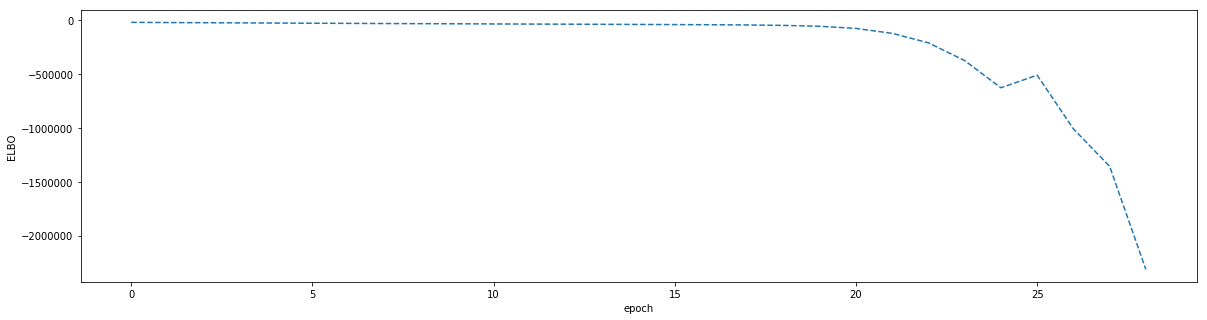

In [28]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(np.array(losses).squeeze(), '--')
ax.set_xlabel('epoch')
_ = ax.set_ylabel('ELBO')

Get learned mean and variance of the process

In [35]:
mean = sess.run(
    tf.cast(
        tf.map_fn(
            gpwink.mean, 
            tf.constant(t_data, dtype=GLOBAL_DTYPE)
        ), 
        dtype=tf.float64
    )
).squeeze()

var = sess.run(
    tf.cast(
        tf.map_fn(
            gpwink.second_moment, 
            tf.constant(t_data, dtype=GLOBAL_DTYPE)
        ), 
        dtype=tf.float64)
).squeeze() - mean**2

Plot real vs learned process

(0, 200)

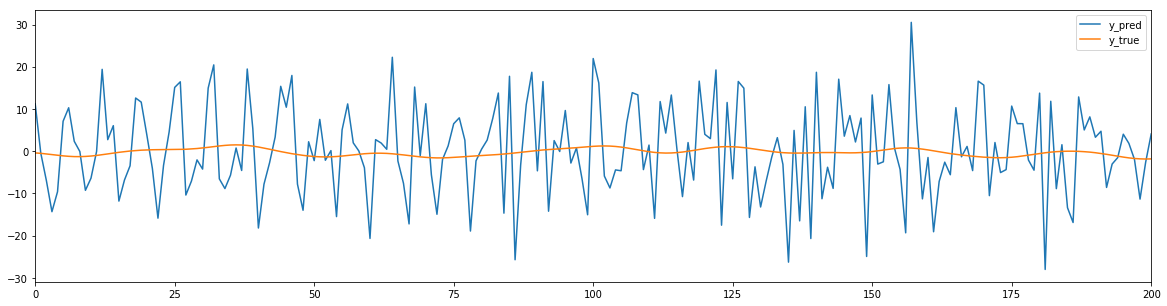

In [72]:
plt.figure(figsize=(20, 5))

plt.plot(t_data, mean, label='y_pred')
plt.plot(t_data, data, label='y_true')
plt.legend()
plt.xlim(0, 200)
# plt.ylim(-10, 10)

Plot real vs learned process (with variance intervals)

Sometimes np.sqrt(var) fails because negative numbers

/home/canas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/home/canas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


(-200, 200)

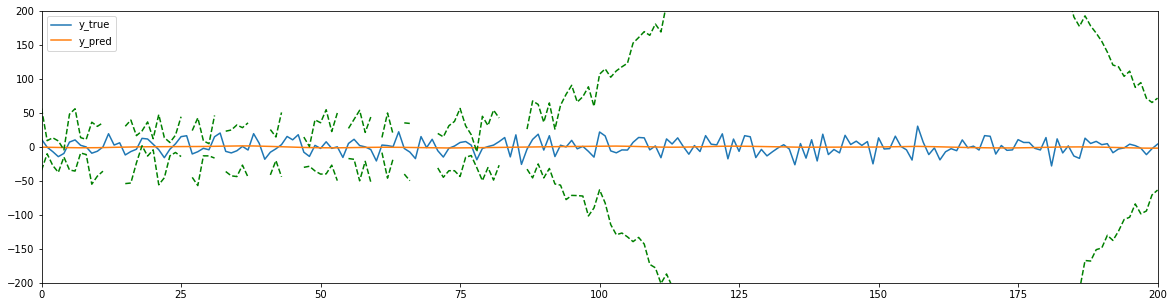

In [43]:
plt.figure(figsize=(20, 5))

plt.plot(t_data, mean, label='y_true')
plt.plot(t_data, data, label='y_pred')
plt.plot(t_data, mean + 2 * np.sqrt(var), 'g--')
plt.plot(t_data, mean - 2 * np.sqrt(var), 'g--')
plt.legend()
plt.xlim(0, 200)
plt.ylim(-200, 200)

Scale $y$ to check shapes

/home/canas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/home/canas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


Text(0.5,1,'y scaled 50 times to check shape')

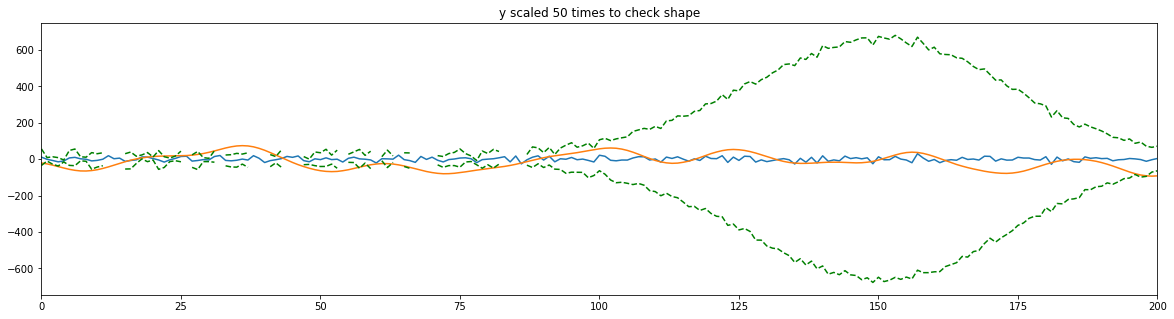

In [57]:
plt.figure(figsize=(20, 5))

scale = 50
plt.plot(t_data, mean, label='y_pred')
plt.plot(t_data, data * scale, label='y_true')
plt.plot(t_data, mean + 2 * np.sqrt(var), 'g--')
plt.plot(t_data, mean - 2 * np.sqrt(var), 'g--')

plt.xlim(0, 200)
#plt.ylim(-10, 10)
plt.title(f'y scaled {scale} times to check shape')

Compare initial vs learned mean of the process

/home/canas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/home/canas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/home/canas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/home/canas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


(-200, 200)

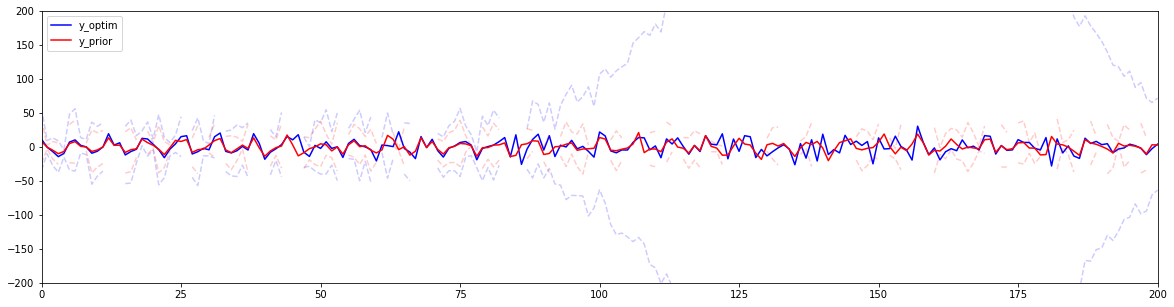

In [47]:
plt.figure(figsize=(20, 5))

plt.plot(t_data, mean,  'b', label='y_optim')
plt.plot(t_data, mean0, 'r', label='y_prior')
#plt.plot(t_data, data, label='y_pred')
plt.plot(t_data, mean + 2 * np.sqrt(var), 'b--', alpha=0.2)
plt.plot(t_data, mean - 2 * np.sqrt(var), 'b--', alpha=0.2)

plt.plot(t_data, mean0 + 2 * np.sqrt(var0), 'r--', alpha=0.2)
plt.plot(t_data, mean0 - 2 * np.sqrt(var0), 'r--', alpha=0.2)
plt.legend()
plt.xlim(0, 200)
plt.ylim(-200, 200)

Check variance values

In [48]:
var.var()

1246233731.0628543

In [49]:
var0.var()

23566.503767614813

filter view

In [ ]:
t_ = np.linspace(-100, 100, 1000)
auh = gpwink.filter_inducing.augmented_interdomain_covariance()(tf.constant(t_, dtype=GLOBAL_DTYPE))
h = tf.transpose(auh) @ gpwink.au_inverse_times_qu_mean()

plt.plot(t_, sess.run(h).real)

<h1> <div style="text-align: center; color: red"> NOTEBOOK ENDS HERE - THE REST ARE TESTING CELLS </div> </h1>

---

In [50]:
assert False

AssertionError: 

### Step-by-Step ELBO

constant term

In [ ]:
import math
PI = tf.constant(math.pi, dtype=GLOBAL_DTYPE)
constant_term = - 0.5 * gpwink.n * tf.log(2. * PI * gpwink.sigma_y**2) \
           - 0.5 * (1 / gpwink.sigma_y**2) * tf.reduce_sum(gpwink.y_obs**2)
eval(constant_term, dtype=np.complex64)

In [ ]:
linear_term = tf.reduce_sum(
        -2.0 * gpwink.y_obs * tf.map_fn(gpwink.mean, gpwink.t_obs, name='linear_term')
    )
eval(linear_term, dtype=np.complex64)

In [ ]:
quadratic_term = tf.reduce_sum(
        tf.map_fn(gpwink.second_moment, gpwink.t_obs, name='quadratic_term')
    )
eval(quadratic_term, dtype=np.complex64)

In [ ]:
from gpwink_tf.kullback_leiblers import kl_complex_gaussian
kl_term = tf.add(
        kl_complex_gaussian(
            gpwink.filter_variational.augmented_mean(),
            gpwink.filter_variational.augmented_covariance(),
            0.,
            gpwink.filter_inducing.augmented_covariance(),
            name='filter_kl'
        ),
        kl_complex_gaussian(
            gpwink.noise_variational.augmented_mean(),
            gpwink.noise_variational.augmented_covariance(),
            0.,
            gpwink.noise_inducing.augmented_covariance(),
            name='noise_kl'
        ),
        name='kl_term'
    )
eval(kl_term, dtype=np.complex64)

In [ ]:
ELBO = constant_term + linear_term + quadratic_term + kl_term
eval(ELBO, dtype=np.complex64)

---

### Step-by-Step Moments

linear term

In [ ]:
auh = gpwink.filter_inducing.augmented_interdomain_covariance()
avx = gpwink.noise_inducing.augmented_interdomain_covariance()

mu = gpwink.mu()
mv = gpwink.mv()

linear_term = tf.reduce_sum(
        -2.0 * gpwink.y_obs * tf.map_fn(gpwink.mean, gpwink.t_obs, name='linear_term')
    )

_ = [sess.run(x) for x in [mu, mv, linear_term]]

In [ ]:
from gpwink_tf.integral import integrate_window_kernel_window, integrate_window
t_new = gpwink.t_obs[1]
m_linear = integrate_window(auh, avx, scale_left=-1, shift_left=t_new)
mean = tf.transpose(gpwink.au_inverse_times_qu_mean()) @ m_linear @ gpwink.av_inverse_times_qv_mean()

quadratic term

In [ ]:
term1 = gpwink.kernel.integrate_along_diagonal(scale=-1, shift=t_new)
sess.run(term1).shape

In [ ]:
from gpwink_tf.integral import integrate_window_kernel_window
term2 = integrate_window_kernel_window(
    avx, gpwink.kernel, avx, scale_mid=(-1, -1),
    shift_mid=(t_new, t_new)
)
sess.run(term2).shape

In [ ]:
term3 = integrate_window(auh, auh, scale_left=-1, shift_left=t_new,
                         scale_right=-1, shift_right=t_new)
sess.run(term3).shape

In [ ]:
term4 = m_linear
sess.run(term4).shape

In [ ]:
from gpwink_tf.utils import my_inner
second_moment = tf.subtract(
    tf.subtract(
        term1,
        my_inner(gpwink.mv(), term2)
    ),
    tf.add(
        my_inner(gpwink.mu(), term3),
        my_inner(gpwink.mu() @ term4, term4 @ gpwink.mv())
    )
)

---

In [ ]:
u = gpwink.filter_inducing
v = gpwink.noise_inducing

In [ ]:
m1 = gpwink.filter_variational.augmented_mean()
c1 = gpwink.filter_variational.augmented_covariance()
m2 = 0.
c2 = gpwink.filter_variational.augmented_covariance()

In [ ]:
eval(kl_complex_gaussian(m1, c1, m2, c2), dtype=np.complex64)

In [ ]:
m1 = gpwink.noise_variational.augmented_mean()
c1 = gpwink.noise_variational.augmented_covariance()
m2 = 0.
c2 = gpwink.noise_inducing.augmented_covariance()

In [ ]:
eval(kl_complex_gaussian(m1, c1, m2, c2), dtype=np.complex64)

In [ ]:
sess.run(- 0.5 * gpwink.n * tf.log(2. * np.pi * tf.square(gpwink.sigma_y)) - 0.5 * (1 / tf.square(gpwink.sigma_y)) * tf.reduce_sum(tf.square(gpwink.y_obs)))

In [ ]:
sess.run(tf.reduce_sum(-2.0 * gpwink.y_obs * tf.map_fn(gpwink.mean, gpwink.t_obs)))

In [ ]:
sess.run(tf.reduce_sum(tf.map_fn(gpwink.second_moment, gpwink.t_obs)))

In [ ]:
sess.run(tf.map_fn(gpwink.second_moment, gpwink.t_obs))

In [ ]:
gpwink.second_moment(gpwink.t_obs[0])

In [ ]:
sess.run(gpwink.second_moment(gpwink.t_obs[0]))

In [ ]:
gpwink.t_obs[0]

In [ ]:
gpwin.second_moment

In [ ]:
N = m1.get_shape()[0].value

In [ ]:
invc1_times_c2 = eval(tf.matrix_solve(c1, c2), dtype=np.complex64)
invc1_times_c2

In [ ]:
invc1_times_diff_m = eval(tf.matrix_solve(c1, m1 - m2), dtype=np.complex64)

In [ ]:
L1 = eval(tf.cholesky(c1), dtype=np.complex64)
L2 = eval(tf.cholesky(c2), dtype=np.complex64)

In [ ]:
sess.run(2 * tf.reduce_sum(tf.log(tf.diag(L1))))

In [ ]:
eval(L1, dtype=np.complex64)

In [ ]:
sess.run(tf.reduce_sum(tf.log(tf.diag_part(L1))))

In [ ]:
L1 = tf.cholesky(c1)
L2 = tf.cholesky(c2)

logdet1 = 2 * eval(tf.reduce_sum(tf.log(tf.diag_part(L1))))
logdet2 = 2 * eval(tf.reduce_sum(tf.log(tf.diag_part(L2))))

In [ ]:
eval(tf.cholesky(c2))

---

In [ ]:
left_window = v._interdomain_transform.scale_and_shift(1, 0)
right_window = v._interdomain_transform.scale_and_shift(1, 0).conjugate()

In [ ]:
for key, value in left_window.params.items():
    print(key, eval(value, dtype=np.complex64))

In [ ]:
left_sigma, left_t2, left_t, left_1 = left_window.get_all_params()

In [ ]:
right_sigma, right_s2, right_s, right_1 = right_window.get_all_params()

In [ ]:
sigma = left_sigma * tf.transpose(right_sigma)

In [ ]:
ct2 = left_t2 + tf.transpose(right_s2)

In [ ]:
ct = left_t + tf.transpose(right_s)

In [ ]:
c1 = left_1 + tf.transpose(right_1)

In [ ]:
eval(
    tf.sqrt(
        np.pi / -ct2
    ),
    dtype=np.complex64
)

In [ ]:
eval(c1, dtype=np.complex64)

In [ ]:
eval(
    (ct**2 / (4 * -ct2)),
    dtype=np.complex64
)

In [ ]:
1/(4 * -eval(ct2, dtype=np.complex64)) + eval(c1, dtype=np.complex64)

In [ ]:
eval(c1, dtype=np.complex64).iloc[1, 1]

In [ ]:
eval(c1, dtype=np.complex64).iloc[1, 1]

In [ ]:
eval(tf.divide(tf.square(ct), (4 * -ct2)), dtype=np.complex64).iloc[1, 1]

In [ ]:
(eval(ct, dtype=np.complex64)**2 / (4 * -eval(ct2, dtype=np.complex64))).iloc[1, 1]

In [ ]:
eval(ct2, dtype=np.complex64)**2

In [ ]:
eval(tf.square(ct2), dtype=np.complex64)

In [ ]:
eval(ct, dtype=np.complex64)

In [ ]:
eval(ct, dtype=np.complex64)**2 / (4 * -eval(ct2, dtype=np.complex64)) 

In [ ]:
(eval(ct, dtype=np.complex64)**2 / (4 * -eval(ct2, dtype=np.complex64))  + eval(c1, dtype=np.complex64))

In [ ]:
eval((tf.square(ct)/ (4 * -ct2)) + c1, dtype=np.complex64)

In [ ]:
(eval(ct, dtype=np.complex64)**2 / (4 * -eval(ct2, dtype=np.complex64)) + eval(c1, dtype=np.complex64))

In [ ]:
eval(
    (ct**2 / (4 * -ct2) + c1),
    dtype=np.complex64
)

In [ ]:
eval(sigma**2 * tf.cast(tf.sqrt(np.pi / tf.cast(-ct2, dtype=tf.float64)), dtype=tf.complex64) * tf.exp(ct**2 / (4 * -ct2) + c1))

In [ ]:


sigma = left_sigma * tf.transpose(right_sigma)
ct2 = left_t2 + tf.transpose(right_s2)
ct = left_t + tf.transpose(right_s)
c1 = left_1 + tf.transpose(right_1)

---

In [ ]:
eval(v._interdomain_transform.scale_and_shift(1, 0).sigma, dtype=np.complex64)

In [ ]:
eval(v.covariance(), dtype=np.complex64)

In [ ]:
eval(v.pseudo_covariance(), dtype=np.complex64)

In [ ]:
np.linalg.eigvals(
    eval(c2, dtype=np.complex64),
)

Upper-left

In [ ]:
np.linalg.eigvals(
    eval(c2[:nv, :nv], dtype=np.complex64),
)

Lower-right

In [ ]:
np.linalg.eigvals(
    eval(c2[nv:, nv:], dtype=np.complex64),
)

Upper-right

In [ ]:
np.linalg.eigvals(
    eval(c2[nv:, :nv], dtype=np.complex64),
)

Lower-left

In [ ]:
np.linalg.eigvals(
    eval(c2[:nv, nv:], dtype=np.complex64),
)

Whole matrix

In [ ]:
sess.run(tf.py_func(np.linalg.cholesky, [c2], c2.dtype))

In [ ]:
np.linalg.cholesky(sess.run( gpwink.noise_inducing.augmented_covariance()))

In [ ]:
np.linalg.cholesky(
    eval(c2, dtype=np.complex64)
)

In [ ]:
show_real(v.covariance())

In [ ]:
for key, value in u._interdomain_transform.params.items():
    print(key, sess.run(value))

In [ ]:
for key, value in v._interdomain_transform.params.items():
    print(key, sess.run(value))

In [ ]:
show_real(v.pseudo_covariance())

In [ ]:
sess.run(tf.diag_part(c2))

In [ ]:
show_imag(c2)